In [30]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pytz
import pandas as pd
import matplotlib.dates as mdates
import metpy.calc as mpcalc
import os, glob
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size':  15})


In [31]:
resultdir = '../../EUREC4A_rad_profiles/output/perturbations/'
# cases = 'baseline','ERA_SST_m021K','ERA_SST_p021K','sondes_q_m3pct','sondes_q_p3pct','ERA_q_m30pct','ERA_q_p30pct'
cases = 'baseline','ERA_SST_m042K','ERA_SST_p042K','sondes_q_m3pct','sondes_q_p3pct','ERA_q_m30pct','ERA_q_p30pct'

col_cases = 'k','blue','darkcyan','red','brown','limegreen','darkgreen'
ls_cases = '-','--','-','--','-','--','-'
# lab_cases = 'baseline','SST-0.21K','SST+0.21K',r'$q_{sonde}$-3%',r'$q_{sonde}$+3%',r'$q_{ERA}$-30%',r'$q_{ERA}$+30%'
lab_cases = 'baseline','SST-0.42K','SST+0.42K',r'$q_{sonde}$-3%',r'$q_{sonde}$+3%',r'$q_{ERA}$-30%',r'$q_{ERA}$+30%'

In [32]:
print('load radiative profiles')

rad_profiles = {}
for case in cases:
    rad_profiles[case] = xr.open_dataset(os.path.join(resultdir,case,'rad_profiles.nc'))

load radiative profiles


In [33]:
print("create mask for points with missing data in target range")

alt_min = 40 # m
alt_max = 40 # m

keep = np.logical_and(rad_profiles['baseline'].z_min.values <= alt_min,\
                              rad_profiles['baseline'].z_max.values >= alt_max)

keep_40m_8km = np.logical_and(rad_profiles['baseline'].z_min.values <= 40,\
                              rad_profiles['baseline'].z_max.values >= 8000)

print("keeping %d profiles"%(np.sum(keep)))

create mask for points with missing data in target range
keeping 1913 profiles


In [34]:
def get_relative_humidity(profiles):
    
    profiles["play"].attrs['units'] = 'hPa'
    profiles["tlay"].attrs['units'] = 'kelvin'
    
    rh = mpcalc.relative_humidity_from_mixing_ratio(profiles["mr"], profiles["tlay"], profiles["play"])
    profiles["rh"] = (["launch_time","zlay"], rh.magnitude)  
    
    return profiles

def get_specific_humidity(profiles):
        
    qv = mpcalc.specific_humidity_from_mixing_ratio(profiles["mr"])
    profiles["qv"] = (["launch_time","zlay"], qv.magnitude)  
    
    return profiles

def plot_average_profiles(profiles,mask):
    
    profiles = get_relative_humidity(profiles)
    profiles = get_specific_humidity(profiles)
       
    tlay_median = profiles["tlay"][mask].quantile(0.5, dim="launch_time")
    tlay_25 = (profiles["tlay"])[mask].quantile(0.25, dim="launch_time")
    tlay_75 = (profiles["tlay"])[mask].quantile(0.75, dim="launch_time")
    tlay_05 = (profiles["tlay"])[mask].quantile(0.05, dim="launch_time")
    tlay_95 = (profiles["tlay"])[mask].quantile(0.95, dim="launch_time")

    qv_median = profiles["qv"][mask].quantile(0.5, dim="launch_time")*1000
    qv_25 = (profiles["qv"])[mask].quantile(0.25, dim="launch_time")*1000
    qv_75 = (profiles["qv"])[mask].quantile(0.75, dim="launch_time")*1000
    qv_05 = (profiles["qv"])[mask].quantile(0.05, dim="launch_time")*1000
    qv_95 = (profiles["qv"])[mask].quantile(0.95, dim="launch_time")*1000

    rh_median = profiles["rh"][mask].quantile(0.5, dim="launch_time")
    rh_25 = (profiles["rh"])[mask].quantile(0.25, dim="launch_time")
    rh_75 = (profiles["rh"])[mask].quantile(0.75, dim="launch_time")
    rh_05 = (profiles["rh"])[mask].quantile(0.05, dim="launch_time")
    rh_95 = (profiles["rh"])[mask].quantile(0.95, dim="launch_time")

    q_rad_median = profiles["q_rad"][mask].quantile(0.5, dim="launch_time")
    q_rad_25 = (profiles["q_rad"])[mask].quantile(0.25, dim="launch_time")
    q_rad_75 = (profiles["q_rad"])[mask].quantile(0.75, dim="launch_time")
    q_rad_05 = (profiles["q_rad"])[mask].quantile(0.05, dim="launch_time")
    q_rad_95 = (profiles["q_rad"])[mask].quantile(0.95, dim="launch_time")

    q_rad_lw_median = profiles["q_rad_lw"][mask].quantile(0.5, dim="launch_time")
    q_rad_lw_25 = (profiles["q_rad_lw"])[mask].quantile(0.25, dim="launch_time")
    q_rad_lw_75 = (profiles["q_rad_lw"])[mask].quantile(0.75, dim="launch_time")
    q_rad_lw_05 = (profiles["q_rad_lw"])[mask].quantile(0.05, dim="launch_time")
    q_rad_lw_95 = (profiles["q_rad_lw"])[mask].quantile(0.95, dim="launch_time")

    q_rad_sw = profiles["q_rad_sw"][mask].where(profiles["q_rad_sw"][mask].mean(dim="zlay") > 0, drop=True)
    q_rad_sw_median = q_rad_sw.quantile(0.5, dim="launch_time")
    q_rad_sw_25 = q_rad_sw.quantile(0.25, dim="launch_time")
    q_rad_sw_75 = q_rad_sw.quantile(0.75, dim="launch_time")
    q_rad_sw_05 = q_rad_sw.quantile(0.05, dim="launch_time")
    q_rad_sw_95 = q_rad_sw.quantile(0.95, dim="launch_time")

    zlay = profiles["zlay"]/1000
    
    fig, ax = plt.subplots(2,3,figsize=(15,15))
    
    ax[0,0].set_xlabel('Temperature (K)')
    ax[0,1].set_xlabel('Specific humidity (g/kg)')
    ax[0,2].set_xlabel('Relative humidity (%)')
    
    ax[0,0].set_ylabel('Altitude (km)')
    ax[1,0].set_ylabel('Altitude (km)')

    fs=16
    ax[0,1].set_title('Environmental means', fontsize=fs)
    ax[1,0].set_title('Shortwave', fontsize=fs)
    ax[1,1].set_title('Longwave', fontsize=fs)
    ax[1,2].set_title('Net', fontsize=fs)

    ax[1,1].set_xlabel('Heating rates (K/day)')
    
    ymin=0.05
    ymax=10
    for k in range(3):
        ax[1,k].set_xlim([-6.5,6.5])
        for i in range (2):
            ax[i,k].grid(color='k', linestyle='--', linewidth=0.8)
            ax[i,k].set_ylim([ymin,ymax]) 
            ax[i,k].tick_params(direction='in', bottom=True, top=True, left=True, right=True,grid_alpha=0.6)
            for axis in ['top','bottom','left','right']:
                ax[i,k].spines[axis].set_linewidth(1.3)
            ax[i,k].spines['right'].set_visible(False)
            ax[i,k].spines['top'].set_visible(False)
        
    cl= "k"
    alpha=0.30
    alpha1=0.10

    ax[0,0].plot(tlay_median, zlay, color=cl, linewidth=1, label="median")
    ax[0,0].fill_betweenx(zlay,tlay_25, tlay_75, alpha=alpha, color=cl, label="25-75%")    
    ax[0,0].fill_betweenx(zlay,tlay_05, tlay_25, alpha=alpha1, color=cl, label="5-95%")    
    ax[0,0].fill_betweenx(zlay,tlay_75, tlay_95, alpha=alpha1, color=cl)    
    ax[0,0].legend(loc="lower left")

    ax[0,1].fill_betweenx(zlay, qv_25, qv_75, alpha=alpha, color=cl)    
    ax[0,1].fill_betweenx(zlay,qv_05, qv_25, alpha=alpha1, color=cl)    
    ax[0,1].fill_betweenx(zlay,qv_75, qv_95, alpha=alpha1, color=cl)    
    ax[0,1].plot(qv_median, zlay, color=cl, linewidth=1)
    
    ax[0,2].fill_betweenx(zlay, rh_25, rh_75, alpha=alpha, color=cl)    
    ax[0,2].fill_betweenx(zlay,rh_05, rh_25, alpha=alpha1, color=cl)    
    ax[0,2].fill_betweenx(zlay,rh_75, rh_95, alpha=alpha1, color=cl)    
    ax[0,2].plot(rh_median, zlay, color=cl, linewidth=1)

    ax[1,0].fill_betweenx(zlay, q_rad_sw_25, q_rad_sw_75, alpha=alpha, color=cl)    
    ax[1,0].fill_betweenx(zlay,q_rad_sw_05, q_rad_sw_25, alpha=alpha1, color=cl)    
    ax[1,0].fill_betweenx(zlay,q_rad_sw_75, q_rad_sw_95, alpha=alpha1, color=cl)    
    ax[1,0].plot(q_rad_sw_median, zlay, color=cl, linewidth=1)
    
    ax[1,1].fill_betweenx(zlay, q_rad_lw_25, q_rad_lw_75, alpha=alpha, color=cl)    
    ax[1,1].fill_betweenx(zlay,q_rad_lw_05, q_rad_lw_25, alpha=alpha1, color=cl)    
    ax[1,1].fill_betweenx(zlay,q_rad_lw_75, q_rad_lw_95, alpha=alpha1, color=cl)    
    ax[1,1].plot(q_rad_lw_median, zlay, color=cl, linewidth=1)
    
    ax[1,2].fill_betweenx(zlay, q_rad_25, q_rad_75, alpha=alpha, color=cl)    
    ax[1,2].fill_betweenx(zlay,q_rad_05, q_rad_25, alpha=alpha1, color=cl)    
    ax[1,2].fill_betweenx(zlay,q_rad_75, q_rad_95, alpha=alpha1, color=cl)    
    ax[1,2].plot(q_rad_median, zlay, color=cl, linewidth=1)
    
    x_text=0.9
    y_text=0.9
    ax[0,0].text(x_text,y_text,'(a)',transform = ax[0,0].transAxes,fontsize=fs)
    ax[0,1].text(x_text,y_text,'(b)',transform = ax[0,1].transAxes,fontsize=fs)
    ax[0,2].text(x_text,y_text,'(c)',transform = ax[0,2].transAxes,fontsize=fs)
    ax[1,0].text(x_text,y_text,'(d)',transform = ax[1,0].transAxes,fontsize=fs)
    ax[1,1].text(x_text,y_text,'(e)',transform = ax[1,1].transAxes,fontsize=fs)
    ax[1,2].text(x_text,y_text,'(f)',transform = ax[1,2].transAxes,fontsize=fs)
    fig.tight_layout() 
    
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)


check the base profiles are similar to the ones before


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


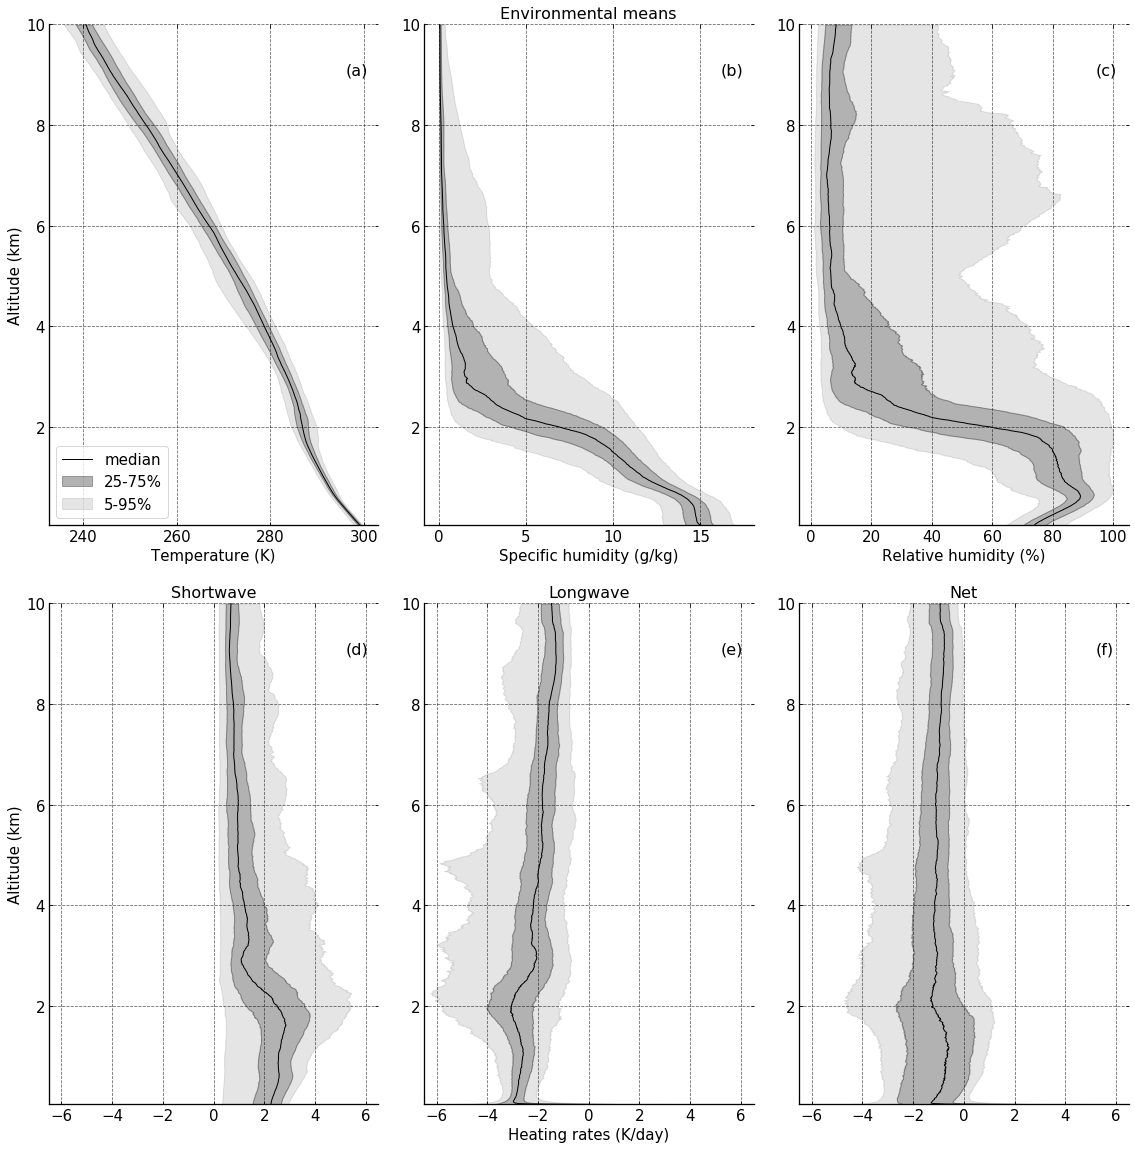

In [35]:
print('check the base profiles are similar to the ones before')

plot_average_profiles(rad_profiles['baseline'],keep)
plt.savefig('../Figures/mean_profiles_threshold_40m.jpeg',bbox_inches="tight")

In [36]:
print("the surface spike in LW seems to correspond the very first non-nan value that is large and positive, for some reason..")
print()
print("see for instance the first few profiles:")
print(rad_profiles['baseline'].q_rad_lw.values[:10,3:7])

the surface spike in LW seems to correspond the very first non-nan value that is large and positive, for some reason..

see for instance the first few profiles:
[[        nan  9.65453022 -0.1357652  -1.29692868]
 [        nan         nan  0.12462438 -2.28063166]
 [        nan         nan -2.15762584 -2.80286218]
 [        nan         nan         nan -1.63307764]
 [        nan         nan  0.79183776 -2.1508379 ]
 [        nan 11.09077522 -0.84058065 -1.92570519]
 [        nan  5.37737992 -1.32528258 -2.07804386]
 [        nan  5.38901836 -2.01882715 -2.62475248]
 [        nan         nan -1.70802423 -2.80759098]
 [        nan  1.18475437 -2.70247135 -2.94570027]]


# Figure 3

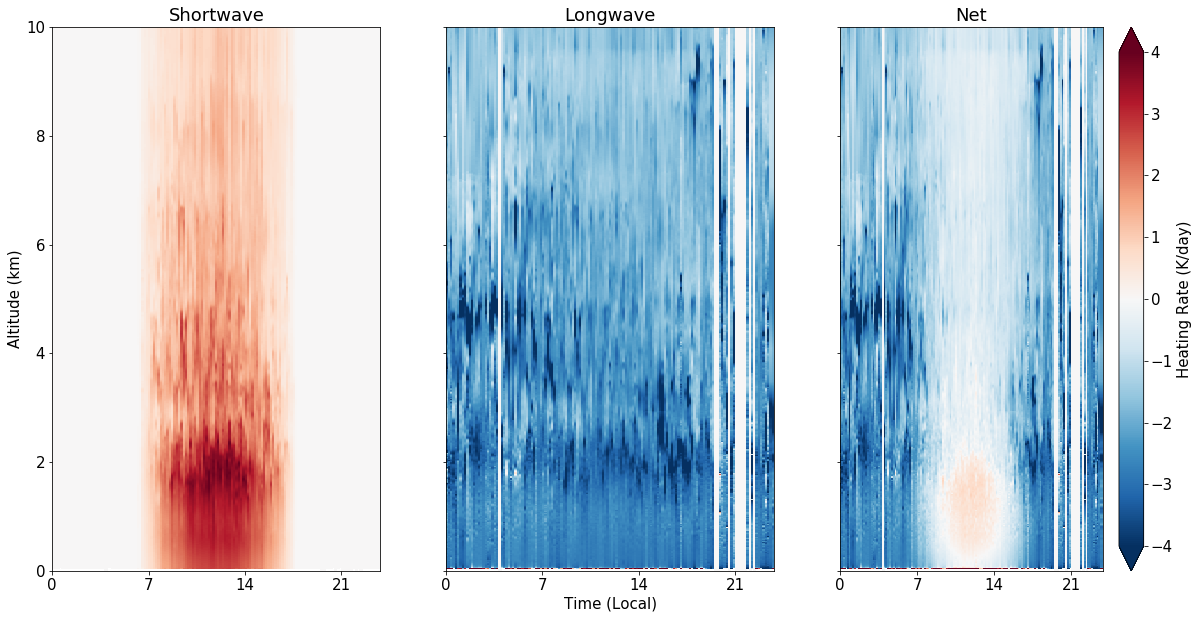

In [37]:
def get_variables_to_plot(profiles,mask):
    
    #get only some coordinates of the original xarray
    data = profiles["q_rad"][mask]
    data["q_rad_lw"] = profiles["q_rad_lw"][mask]
    data["q_rad_sw"] = profiles["q_rad_sw"][mask]
    data["time"] = profiles["launch_time"][mask]
    data = data.drop_vars(["lay","col"])
    
    data = data.to_dataframe()
    data["time"] = data["time"].dt.tz_localize(pytz.UTC).dt.tz_convert('America/Barbados').dt.strftime("%H:%M")
    
    data["time"] = pd.to_datetime(data["time"], format="%H:%M")

    data = data.reset_index()
    data = data.set_index(["time","zlay"])
    data = data.groupby([pd.Grouper(freq='10min', level='time'), 
                                 pd.Grouper(level='zlay')]).mean()
        
    #come back to xarray and get q_rad
    data = data.to_xarray()
    time = data.time.values
    zlay = data.zlay.values
        
    #fill values with 0 in a new array
    ini = np.datetime64('1900-01-01 00:00:00')
    end = ini + np.timedelta64(24,'h')
    count_time = np.arange(ini, end, np.timedelta64(10, 'm'))

    q_rad = np.zeros((len(count_time), len(zlay)))
    q_rad_sw = np.zeros((len(count_time), len(zlay)))
    q_rad_lw = np.zeros((len(count_time), len(zlay)))

    ds =  xr.Dataset({'q_rad': (['count_time', 'zlay'],  q_rad),
                       'q_rad_sw': (['count_time', 'zlay'],  q_rad_sw),
                        'q_rad_lw': (['count_time', 'zlay'],  q_rad_lw)},
                    coords={"count_time": count_time, "zlay": zlay})

    array = ds.to_dataframe()

    for itime in time:
        for izlay in zlay:
            array.q_rad.loc[itime, izlay] = data["q_rad"].sel(time=itime).sel(zlay=izlay).values
            array.q_rad_lw.loc[itime, izlay] = data["q_rad_lw"].sel(time=itime).sel(zlay=izlay).values
            array.q_rad_sw.loc[itime, izlay] = data["q_rad_sw"].sel(time=itime).sel(zlay=izlay).values
    
    data = array.to_xarray()
    
    q_rad = np.transpose(data.q_rad.values)
    q_rad_lw = np.transpose(data.q_rad_lw.values)
    q_rad_sw = np.transpose(data.q_rad_sw.values)
    zlay = data.zlay.values
    time = data.count_time.values
        
    return time, zlay, q_rad, q_rad_lw, q_rad_sw

def plot_diurnal_cycle(profiles,mask):
    
    time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_to_plot(profiles,mask)   
 
    dates_list = [date for date in time]    
        
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    
    ax[0].set_title(r'Shortwave')
    ax[0].set_ylabel('Altitude (km)')
    ax[1].set_title('Longwave')
    ax[1].set_xlabel('Time (Local)')
    ax[2].set_title(r'Net')

    ymin=0
    ymax=10
    
    colormap = matplotlib.cm.get_cmap("RdBu_r")
    val_min = -4
    val_max = 4

    zlay=zlay/1000
    
    ax[0].pcolormesh(dates_list, zlay, q_rad_sw, cmap=colormap,vmin=val_min, vmax=val_max)
    ax[1].pcolormesh(dates_list, zlay, q_rad_lw, cmap=colormap,vmin=val_min,vmax=val_max)
    im = ax[2].pcolormesh(dates_list, zlay, q_rad, cmap=colormap,vmin=val_min, vmax=val_max)
    
    myFmt = mdates.DateFormatter('%-H')
    
    for k in range(3):
        ax[k].xaxis.set_major_formatter(myFmt)
        ax[k].set_ylim([0,ymax])
    

    for k in range(3):
        ticks = ax[k].get_xticks()
        ax[k].set_xticks(np.linspace(ticks[0], mdates.date2num(mdates.num2date(ticks[-1])), 4))

    ax[1].tick_params(labelleft=False)    
    ax[2].tick_params(labelleft=False)    

    cb = fig.colorbar(im, ax=ax[2], extend="both")
    cb.ax.set_ylabel('Heating Rate (K/day)')
        
    fig.savefig('../Figures/Fig4_Diurnal_composite.jpg')
    
plot_diurnal_cycle(rad_profiles['baseline'],keep)

# Figure 5

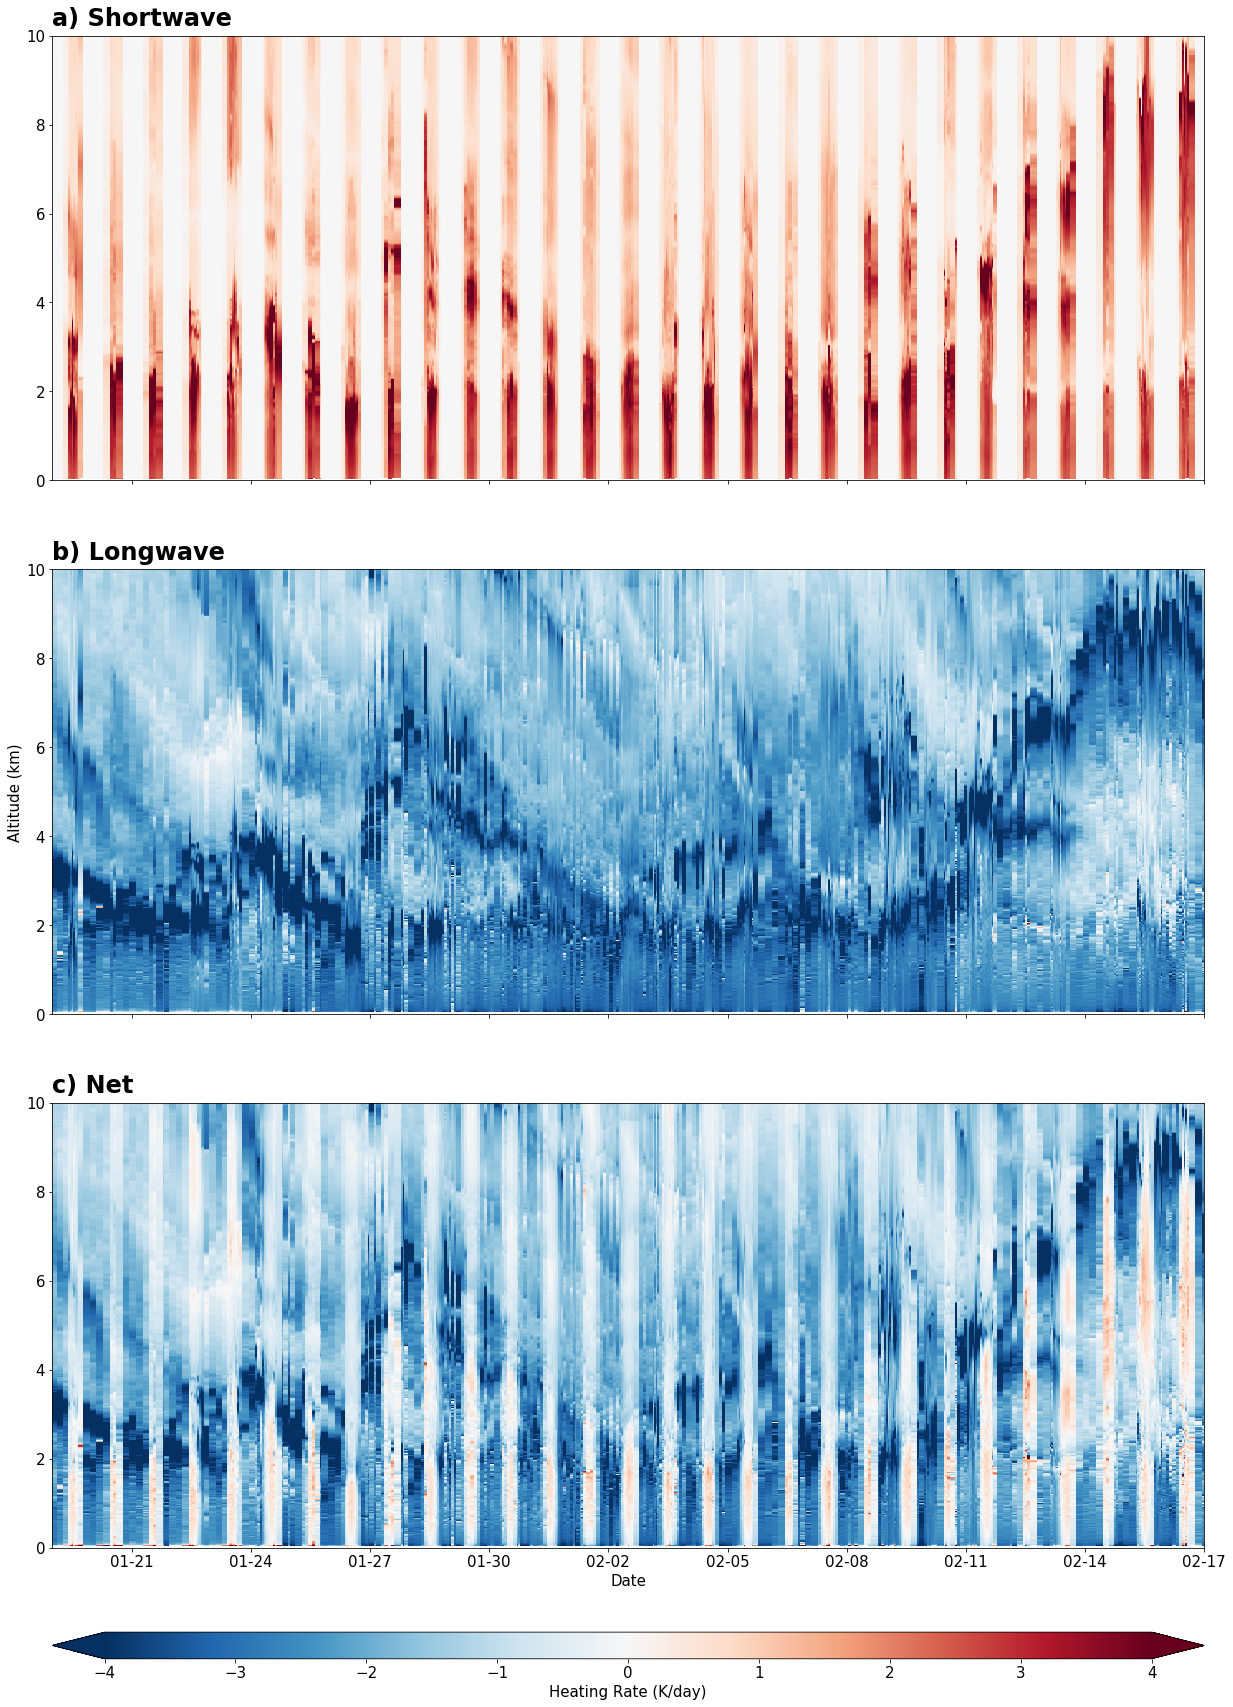

In [38]:
def get_variables_day_to_day(profiles,mask):

    data = profiles["q_rad"][mask]
    data["q_rad_sw"] = profiles["q_rad_lw"][mask]
    data["q_rad_lw"] = profiles["q_rad_sw"][mask]

    data["time"] = profiles["launch_time"][mask]
    data = data.drop_vars(["lay","col"])
    
    data = data.to_dataframe()
    data["time"] = data["time"].dt.tz_localize(pytz.UTC).dt.tz_convert('America/Barbados').dt.strftime("%Y%m%dT%H")
    
    data["time"] = pd.to_datetime(data["time"], format="%Y%m%dT%H")

    data = data.reset_index()
    data = data.set_index(["time","zlay"])
    data = data.groupby([pd.Grouper(freq='1H', level='time', label="right"), 
                                 pd.Grouper(level='zlay')]).mean()
    
    #come back to xarray and get q_rad
    data = data.to_xarray()
    
    time = data.time.values
    zlay = data.zlay.values
    q_rad = np.transpose(data.q_rad.values)
    q_rad_sw = np.transpose(data.q_rad_lw.values)
    q_rad_lw = np.transpose(data.q_rad_sw.values)

    return time, zlay, q_rad, q_rad_lw, q_rad_sw

def plot_day_to_day(profiles,mask):

    time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_day_to_day(profiles,mask)

    dates_list = [date for date in time]

    fig, ax = plt.subplots(3,1,figsize=(20,30))

    fig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

    pad=10
    fs=24
    loc="left"
    fw="bold"
    ax[0].set_title(r'a) Shortwave', loc=loc, pad=pad,fontsize=fs, fontweight=fw)
    ax[1].set_title(r'b) Longwave', loc=loc, pad=pad, fontsize=fs, fontweight=fw)
    ax[2].set_title(r'c) Net', loc=loc, pad=pad, fontsize=fs, fontweight=fw)

    ax[1].set_ylabel('Altitude (km)')
    ax[2].set_xlabel('Date')

    ymin=0
    ymax=10

    colormap = matplotlib.cm.get_cmap("RdBu_r")
    val_min = -4
    val_max = 4

    zlay=zlay/1000

    ax[0].pcolormesh(dates_list, zlay, q_rad_sw, cmap=colormap,vmin=val_min, vmax=val_max)
    ax[1].pcolormesh(dates_list, zlay, q_rad_lw, cmap=colormap,vmin=val_min, vmax=val_max)
    im = ax[2].pcolormesh(dates_list, zlay, q_rad, cmap=colormap,vmin=val_min, vmax=val_max)

    myFmt = mdates.DateFormatter('%m-%d')

    ini = np.datetime64('2020-01-19 00:00:00')
    end = np.datetime64('2020-02-17 00:00:00')

    for k in range(3):
        ax[k].xaxis.set_major_formatter(myFmt)
        ax[k].set_ylim([0,ymax])
        ax[k].set_xlim([ini,end])

    for k in range(3):
        ticks = ax[k].get_xticks()
        ax[k].set_xticks(np.linspace(ticks[0], ticks[-1], 10))

    ax[0].tick_params(labelbottom=False)
    ax[1].tick_params(labelbottom=False)

    x,y,w,h = ax[2].get_position().bounds
    c_map_ax = fig.add_axes([x, y-0.25*h, 1*w, 0.06*h])
    cbar = fig.colorbar(im,cax=c_map_ax, orientation="horizontal", extend="both")
    cbar.ax.set_xlabel('Heating Rate (K/day)',color='k') # cbar legend   

    fig.savefig('../Figures/Fig5_Day_to_day_variability.jpg')
    
plot_day_to_day(rad_profiles['baseline'],keep)

# RMSE

In [39]:
rad_profiles['baseline'].q_rad.shape

(2504, 1000)

In [40]:
def rmse(q_rad_1,q_rad_2):
    
    return np.sqrt(np.mean((q_rad_1-q_rad_2)**2,axis=0))

def rmse_relative(q_rad_1,q_rad_2):
    
    return np.sqrt(np.mean((q_rad_1-q_rad_2)**2,axis=0))/np.absolute(np.mean(q_rad_1,axis=0))



/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty sli

1913 profiles retained with data above 40m
1314 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1117 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1913 profiles retained with data above 40m
1314 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1117 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty sli

1913 profiles retained with data above 40m
1913 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1625 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1913 profiles retained with data above 40m
1913 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1625 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1913 profiles retained with data above 40m
1913 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1625 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1913 profiles retained with data above 40m
1913 profiles retained during daytime with data above 40m
1625 profiles retained with data between 40m and 8km
1625 profiles retained during daytime with data between 40m and 8km


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


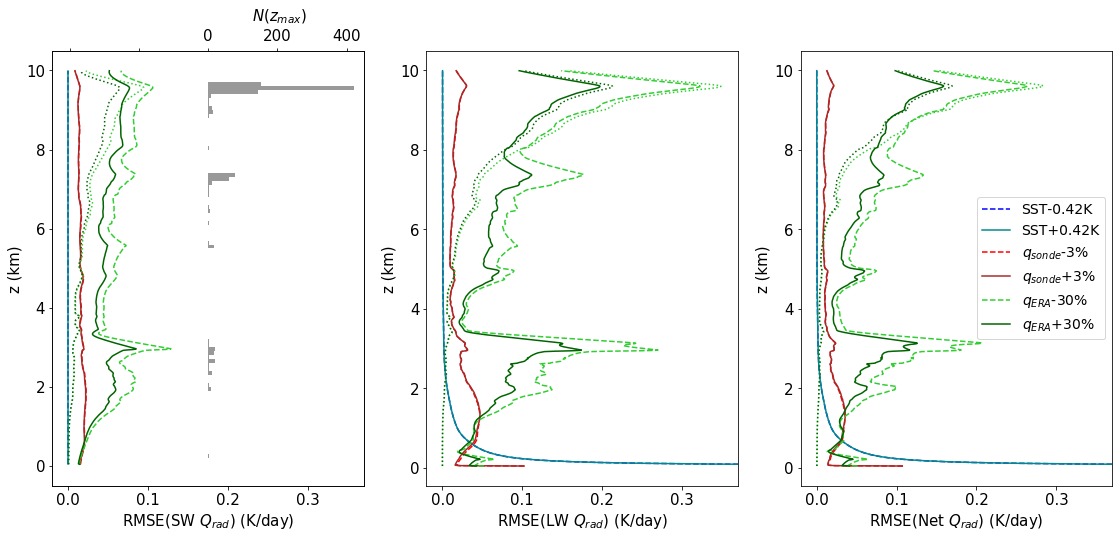

In [43]:

q_rad_varids = 'q_rad_sw','q_rad_lw','q_rad'
x_labels = r'SW', r'LW',r'Net'

zlay = rad_profiles['baseline']["zlay"]/1000

fig,axs = plt.subplots(ncols=3,figsize=(19,8))

##--- show histogram of z_max on panel (c)

zmin = np.min(rad_profiles['baseline'].zlev.values)/1000
zmax = np.max(rad_profiles['baseline'].zlev.values)/1000

z_bins = np.arange(zmin,zmax,0.1)
# count,z_bins = np.histogram(rad_profiles['baseline'].z_max.values,bins=z_bins)
# z_centers = np.convolve(z_bins,[0.5,0.5],mode='valid')
# print(z_centers,count)

ax_zmax = axs[0].twiny()
ax_zmax.hist(rad_profiles['baseline'].z_max.values/1000,bins=z_bins,
             orientation='horizontal',
             rwidth=1,
             color='k',
             alpha=0.4)

ax_zmax.set_xlim((-450,450))

# ticks = []
# for tick in ax_zmax.get_xticklabels():
#     if '\u2212' in tick.get_text():
#         tick.set_text('')
#         ticks.append(tick)
## Manually.....
ax_zmax.set_xticklabels(['','','','0','200','400'])
ax_zmax.set_xlabel(r'$N(z_{max})$')
ax_zmax.xaxis.set_label_coords(0.73,1.07)

##--- show all error curves

for i in range(3):
    
    ax = axs[i]
    varid = q_rad_varids[i]
    
    for i_c in range(1,7):
        case = cases[i_c]
        
        keep_day = np.ones((rad_profiles[case].dims['launch_time'],),dtype=bool)
        if varid == 'q_rad_sw':
            keep_day = (rad_profiles[case]["q_rad_sw"].mean(dim="zlay") > 0)
        
        mask = np.logical_and(keep,keep_day)

#         keep_day = (rad_profiles[case]["q_rad_sw"].mean(dim="zlay") > 0)
#         mask = np.logical_and(keep,keep_day)
        
        rmse2show = rmse(rad_profiles['baseline'][varid][mask],rad_profiles[case][varid][mask])
#         rmse2show = rmse_relative(rad_profiles['baseline'][varid][mask],rad_profiles[case][varid][mask])
        ax.plot(rmse2show,zlay,c=col_cases[i_c],linestyle=ls_cases[i_c],label=lab_cases[i_c])
    
        if i_c in [5,6]:
            # Change mask for ERA, keeping profiles with valid data between 40m and 8km
            mask_40m_8km = np.logical_and(keep_40m_8km,keep_day)
            print('%d profiles retained with data above 40m'%(keep.sum()))
            print('%d profiles retained during daytime with data above 40m'%(mask.sum()))
            print('%d profiles retained with data between 40m and 8km'%keep_40m_8km.sum())
            print('%d profiles retained during daytime with data between 40m and 8km'%mask_40m_8km.sum())
            rmse2show = rmse(rad_profiles['baseline'][varid][mask_40m_8km],rad_profiles[case][varid][mask_40m_8km])
            ax.plot(rmse2show,zlay,c=col_cases[i_c],linestyle=':')
    
    ax.set_xlabel('RMSE(%s $Q_{rad}$) (K/day)'%x_labels[i])
    ax.set_ylabel('z (km)')
    ax.set_xlim((-0.02,0.37))
    

##--- show legend on panel (a)
axs[2].legend(fontsize=14)



plt.savefig('../Figures/perturbations.pdf',bbox_inches='tight')
# plt.savefig('../Figures/perturbations.jpg',bbox_inches='tight')
plt.show()

In [42]:
plat_names = list(set(rad_profiles['baseline'].platform.values))
count = []
for plat_name in plat_names:
    count.append((rad_profiles['baseline'].platform.values == plat_name).sum())
    print(plat_name, count[-1])

dict_count = dict(zip(plat_names,count))
count_dropsondes = dict_count['P3']+dict_count['HALO']

print()
print('%d dropsondes'%count_dropsondes)
print('%d radiosondes'%(np.sum(count)-count_dropsondes))
print('%d sondes in total'%np.sum(count))

HALO 807
BCO 342
RHB 309
MER 147
ATL 276
MET 362
P3 261

1068 dropsondes
1436 radiosondes
2504 sondes in total
